In [1]:
from tensorflow import keras
import cv2
import numpy as np

In [2]:
model = keras.models.load_model('soybeans.h5', compile=False)
label_name = ["Good", "Bad"]
net = cv2.dnn.readNet("yolov4-tiny_final.weights", "yolov4-tiny.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [3]:
def yolo_detect(img):
    
    height, width, channels = img.shape 
    
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            tx, ty, tw, th, confidence = detection[0:5]
            
            scores = detection[5:]
            class_id = np.argmax(scores)  
            if confidence > 0.5:   
                center_x = int(tx * width)
                center_y = int(ty * height)
                w = int(tw * width)
                h = int(th * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)
    
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i] 
            img_crop = img[y:y+h, x:x+w]
            try:
                img_RGB = cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB)
                img_resize = cv2.resize(img_RGB, (224,224))
                img_normal = img_resize.astype('float32')/255
                img_reshape = np.expand_dims(img_normal,0)
                predict = model.predict(img_reshape)[0]
                if predict[1]>0.5:
                    cv2.rectangle(img, (x, y), (x + w, y + h), (0,0,225), 2)
                    cv2.putText(img, "Bad", (x, y -5), font, 0.5, (0,0,225), 1)
                else:
                    cv2.rectangle(img, (x, y), (x + w, y + h), (225,0,0), 2)
                    cv2.putText(img, "Good", (x, y -5), font, 0.5, (225,0,0), 1)
            except:
                continue
    return img

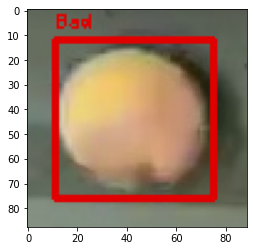

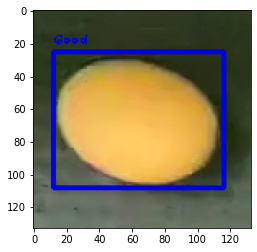

In [4]:
from matplotlib import pyplot as plt

img = cv2.imread("img/bad05_1.jpg")
im = yolo_detect(img)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

img = cv2.imread("img/good01_102.jpg")
im = yolo_detect(img)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
import cv2
import time

VIDEO_IN = cv2.VideoCapture(0)

while True:
    hasFrame, frame = VIDEO_IN.read()
    img = yolo_detect(frame)
    cv2.imshow("Frame", img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
VIDEO_IN.release()
cv2.destroyAllWindows()